In [ ]:
# !pip install tensorflow_addons keras_cv_attention_models python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.5/572.5 KB 8.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
!gcloud auth application-default login --no-launch-browser
auth.authenticate_user()

Mounted at /content/drive
Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=yHyTRD7vaanzRnTbbLBd3KD0cDPetG&prompt=consent&access_type=offline&code_challenge=nZlFTDncr9MstJl3M5LHFm1Wtui8FiqeFgAuqgBEl0Y&code_challenge_method=S256

Enter authorization code: 4/0AWtgzh64XaBSunOrcj7SJf-qnf2YeEhxMRFcb78Pa2PWO2EXw4IdKfxe3hQHr6PNa6Q-IA

Credentials saved to file: [/content/.config/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).
Cannot find a 

/usr/local/lib/python3.8/dist-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [ ]:
%cd drive/MyDrive/cancer
!gcloud config set project kaggle-376710

/content/drive/MyDrive/cancer
Updated property [core/project].


In [ ]:
!cp /content/.config/application_default_credentials.json /content/adc.json

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_gcs_config

import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from sklearn.model_selection import train_test_split
from keras_cv_attention_models import convnext

import os
import time
import pickle
import math
import random
import sys
import cv2
import gc
from datetime import datetime
import warnings; warnings.simplefilter('ignore')
import dotenv
dotenv.load_dotenv()

sys.path.append('..')
from config import CFG
CFG = CFG()
print(f'Tensorflow Version: {tf.__version__}')
print(f'Python Version: {sys.version}')

Tensorflow Version: 2.9.2
Python Version: 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]


In [ ]:
now = datetime.now().strftime("%d-%b-%Y %H-%M-%S")
np.save(now, np.array([now]))

In [ ]:
# float32 or mixed_float16 (mixed precision: compute float16, variable float32)
# TPU is fast enough and has enough memory to use float32
policy = tf.keras.mixed_precision.Policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

print(f'Compute dtype: {tf.keras.mixed_precision.global_policy().compute_dtype}')
print(f'Variable dtype: {tf.keras.mixed_precision.global_policy().variable_dtype}')

Compute dtype: float32
Variable dtype: float32


In [ ]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    IS_TPU = True
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    STRATEGY = tf.distribute.experimental.TPUStrategy(TPU)
else:
    IS_TPU = False
    STRATEGY = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = STRATEGY.num_replicas_in_sync
tensorflow_gcs_config.configure_gcs_from_colab_auth()
print(f'N_REPLICAS: {N_REPLICAS}, IS_TPU: {IS_TPU}')

Running on TPU  grpc://10.40.193.90:8470


N_REPLICAS: 8, IS_TPU: True


In [ ]:
SEED = CFG.SEED
DEBUG = False

# Image dimensions
IMG_HEIGHT = CFG.IMG_HEIGHT
IMG_WIDTH = CFG.IMG_WIDTH
N_CHANNELS = CFG.N_CHANNELS
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)
N_SAMPLES_TFRECORDS = CFG.N_SAMPLES_RECORD

# Peak Learning Rate
LR_MAX = CFG.LR_MAX * N_REPLICAS
WD_RATIO = CFG.WD_RATIO

N_WARMUP_EPOCHS = CFG.WARMUP_EPOCHS
N_EPOCHS = CFG.EPOCHS

# Batch size
BATCH_SIZE = CFG.BATCH_SIZE * N_REPLICAS

# Is Interactive Flag and COrresponding Verbosity Method
IS_INTERACTIVE = False
VERBOSE = 1 if IS_INTERACTIVE else 2

# Tensorflow AUTO flag
AUTO = tf.data.experimental.AUTOTUNE

print(f'BATCH_SIZE: {BATCH_SIZE}')

BATCH_SIZE: 64


In [ ]:
# Seed all random number generators
def seed_everything(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything()

In [ ]:
# Train DataFrame
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample_submission.csv')

In [ ]:
# short Tensorflow randin integer function
def tf_rand_int(minval, maxval, dtype=tf.int64):
    minval = tf.cast(minval, dtype)
    maxval = tf.cast(maxval, dtype)
    return tf.random.uniform(shape=(), minval=minval, maxval=maxval, dtype=dtype)

# chance of 1 in k
def one_in(k):
    return 0 == tf_rand_int(0, k)
# Function to benchmark the dataset
def benchmark_dataset(dataset, num_epochs=3, n_steps_per_epoch=10, bs=BATCH_SIZE):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for idx, (inputs, labels) in enumerate(dataset.take(n_steps_per_epoch + 1)):
            if idx == 0:
                epoch_start = time.perf_counter()
            elif idx == 1 and epoch_num == 0:
                image = inputs['image']
                print(f'image shape: {image.shape}, labels shape: {labels.shape}, image dtype: {image.dtype}, labels dtype: {labels.dtype}')
            else:
                pass
        
        epoch_t = time.perf_counter() - epoch_start
        mean_step_t = round(epoch_t / n_steps_per_epoch * 1000, 1)
        n_imgs_per_s = int(1 / (mean_step_t / 1000) * bs)
        print(f'epoch {epoch_num} took: {round(epoch_t, 2)} sec, mean step duration: {mean_step_t}ms, images/s: {n_imgs_per_s}')

# Plots a batch of images
def show_batch(dataset, n_rows=16, n_cols=4):
    inputs, targets = next(iter(dataset))
    images = inputs['image'].numpy().squeeze()
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*4, n_rows*7))
    for r in range(n_rows):
        for c in range(n_cols):
            idx = r * n_cols + c
            # Image
            img = images[idx]
            axes[r, c].imshow(img)
            # Target
            target = targets[idx]
            axes[r, c].set_title(f'target: {target}', fontsize=16, pad=5)
        
    plt.show()

# Decodes the TFRecords
def decode_image(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64),
        'patient_id': tf.io.FixedLenFeature([], tf.int64),
    })
    
    # Decode PNG Image
    image = tf.io.decode_jpeg(features['image'], channels=N_CHANNELS)
    # Explicit reshape needed for TPU
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, N_CHANNELS])

    target = features['target']
    
    return { 'image': image }, target

def augment_image(X, y):
    image = X['image']
    
    # Random Brightness
    image = tf.image.random_brightness(image, 0.10)
    
    # Random Contrast
    image = tf.image.random_contrast(image, 0.90, 1.10)
    
    # Random JPEG Quality
    image = tf.image.random_jpeg_quality(image, 75, 100)
    
    # Random crop image with maximum of 10%
    ratio = tf.random.uniform([], 0.75, 1.00)
    img_height_crop = tf.cast(ratio * IMG_HEIGHT, tf.int32)
    img_width_crop = tf.cast(ratio * IMG_WIDTH, tf.int32)
    # Random offset for crop
    img_height_offset = tf_rand_int(0, IMG_HEIGHT - img_height_crop)
    img_width_offset = 0
    # Crop And Resize
    image = tf.slice(image, [img_height_offset, img_width_offset, 0], [img_height_crop, img_width_crop, N_CHANNELS])
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR)
    # Clip pixel values in range [0,255] to prevent underflow/overflow
    image = tf.clip_by_value(image, 0, 255)
    image = tf.cast(image, tf.uint8)
    
    return { 'image': image }, y

# Undersample majority class (0/negative) by randomly dropping them
def undersample_majority(X, y):
    # Filter 2/3 of negative samples to upsample positive samples by a factor 3
    return y == 1 or tf.random.uniform([]) > 0.66

In [ ]:
# TFRecord file paths
TFRECORDS_FILE_PATHS = sorted(tf.io.gfile.glob('gs://kaggle-creds/tfrecords/*.tfrecords'))
print(f'Found {len(TFRECORDS_FILE_PATHS)} TFRecords')

Found 100 TFRecords


In [ ]:
# Train Test Split
TFRECORDS_TRAIN, TFRECORDS_VAL = train_test_split(TFRECORDS_FILE_PATHS, train_size=0.80, random_state=SEED, shuffle=True)
print(f'# TFRECORDS_TRAIN: {len(TFRECORDS_TRAIN)}, # TFRECORDS_VAL: {len(TFRECORDS_VAL)}')

# TFRECORDS_TRAIN: 80, # TFRECORDS_VAL: 20


In [ ]:
def get_dataset(tfrecords, bs=BATCH_SIZE, val=False, debug=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    
    # Initialize dataset with TFRecords
    dataset = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=AUTO, compression_type='GZIP')
    
    # Decode mapping
    dataset = dataset.map(decode_image, num_parallel_calls=AUTO)

    if not val:
        dataset = dataset.filter(undersample_majority)
        dataset = dataset.map(augment_image, num_parallel_calls=AUTO)
        dataset = dataset.with_options(ignore_order)
        if not debug:
            dataset = dataset.shuffle(1024)
        dataset = dataset.repeat()        

    dataset = dataset.batch(bs, drop_remainder=not val)
    dataset = dataset.prefetch(AUTO)
    
    return dataset

In [ ]:
# Get Train/Validation datasets
train_dataset = get_dataset(TFRECORDS_TRAIN, val=False, debug=False)
val_dataset = get_dataset(TFRECORDS_VAL, val=True, debug=False)

TRAIN_STEPS_PER_EPOCH = len(TFRECORDS_TRAIN) * N_SAMPLES_TFRECORDS // BATCH_SIZE
VAL_STEPS_PER_EPOCH = len(TFRECORDS_VAL) * N_SAMPLES_TFRECORDS // BATCH_SIZE
print(f'TRAIN_STEPS_PER_EPOCH: {TRAIN_STEPS_PER_EPOCH}, VAL_STEPS_PER_EPOCH: {VAL_STEPS_PER_EPOCH}')

TRAIN_STEPS_PER_EPOCH: 685, VAL_STEPS_PER_EPOCH: 171


In [ ]:
# Sanity check, image and label statistics
X_batch, y_batch = next(iter(get_dataset(TFRECORDS_TRAIN, val=False)))
image = X_batch['image'].numpy()
print(f'image shape: {image.shape}, y_batch shape: {y_batch.shape}')
print(f'image dtype: {image.dtype}, y_batch dtype: {y_batch.dtype}')
print(f'image min: {image.min():.2f}, max: {image.max():.2f}')

image shape: (64, 1344, 768, 1), y_batch shape: (64,)
image dtype: uint8, y_batch dtype: <dtype: 'int64'>
image min: 0.00, max: 255.00


In [ ]:
# Show what we will be training on
show_batch(get_dataset(TFRECORDS_TRAIN, bs=64, val=False))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Label Distribution Train With Undersampled Majority Class
N = BATCH_SIZE
train_labels = []
for _, labels in tqdm(get_dataset(TFRECORDS_TRAIN, val=False).take(N), total=N):
    train_labels += labels.numpy().tolist()
    
display(pd.concat((
        pd.Series(train_labels).value_counts(normalize=True).to_frame('Train Label Ratio'),
        pd.Series(train_labels).value_counts().to_frame('Train Label Count'),
    ), axis=1)
)

  0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function Executor.__del__ at 0x7f01cc5c4820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


,Train Label Ratio,Train Label Count
0,0.938965,3846
1,0.061035,250


In [ ]:
# Label Distribution Validation (Unchanged)
val_labels = []
for _, labels in tqdm(get_dataset(TFRECORDS_VAL, val=True), total=VAL_STEPS_PER_EPOCH):
    val_labels += labels.numpy().tolist()
    
display(pd.concat((
        pd.Series(val_labels).value_counts(normalize=True).to_frame('Val Label Ratio'),
        pd.Series(val_labels).value_counts().to_frame('Val Label Count'),
    ), axis=1)
)

  0%|          | 0/171 [00:00<?, ?it/s]

Exception ignored in: <function Executor.__del__ at 0x7f01cc5c4820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


,Val Label Ratio,Val Label Count
0,0.982089,10747
1,0.017911,196


In [ ]:
class pF1(tf.keras.metrics.Metric):
    def __init__(self, name='pF1', **kwargs):
        super(pF1, self).__init__(name=name, **kwargs)
        self.tc = self.add_weight(name='tc', initializer='zeros')
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.tc.assign_add(tf.cast(tf.reduce_sum(y_true), tf.float32))
        self.tp.assign_add(tf.cast(tf.reduce_sum((y_pred[y_true == 1])), tf.float32))
        self.fp.assign_add(tf.cast(tf.reduce_sum((y_pred[y_true == 0])), tf.float32))

    def result(self):
        if self.tc == 0 or (self.tp + self.fp) == 0:
            return 0.0
        else:
            precision = self.tp / (self.tp + self.fp)
            recall = self.tp / (self.tc)
            return 2 * (precision * recall) / (precision + recall)

    def reset_state(self):
        self.tc.assign(0)
        self.tp.assign(0)
        self.fp.assign(0)

In [ ]:
def normalize(image):
    # Repeat channels to create 3 channel images required by pretrained ConvNextV2 models
    image = tf.repeat(image, repeats=3, axis=3)
    # Cast to float 32
    image = tf.cast(image, tf.float32)
    # Normalize with respect to ImageNet mean/std
    image = tf.keras.applications.imagenet_utils.preprocess_input(image, mode='torch')

    return image

def get_model():
    print(f'Compute dtype: {tf.keras.mixed_precision.global_policy().compute_dtype}')
    print(f'Variable dtype: {tf.keras.mixed_precision.global_policy().variable_dtype}')

    with STRATEGY.scope():
        seed_everything()
        image = tf.keras.layers.Input(shape=INPUT_SHAPE, name='image', dtype=tf.uint8)
        image_norm = normalize(image)
        x = convnext.ConvNeXtV2Tiny(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
            pretrained='imagenet21k-ft1k',
            num_classes=0
        )(image_norm)
        
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        optimizer = tf.keras.optimizers.Adam(learning_rate=LR_MAX, decay=LR_MAX * WD_RATIO, epsilon=1e-6)

        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

        metrics = [
            pF1(),
            tfa.metrics.F1Score(num_classes=1, threshold=0.5),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.BinaryAccuracy(),
        ]

        model = tf.keras.Model(inputs=image, outputs=output)

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        return model

In [ ]:
tf.keras.backend.clear_session()
# enable XLA optmizations
tf.config.optimizer.set_jit(True)

model = get_model()

Compute dtype: float32
Variable dtype: float32
115145456/115145456 [==============================] - 2s 0us/step
>>>> Load pretrained from: /root/.keras/models/convnext_v2_tiny_384_imagenet21k-ft1k.h5


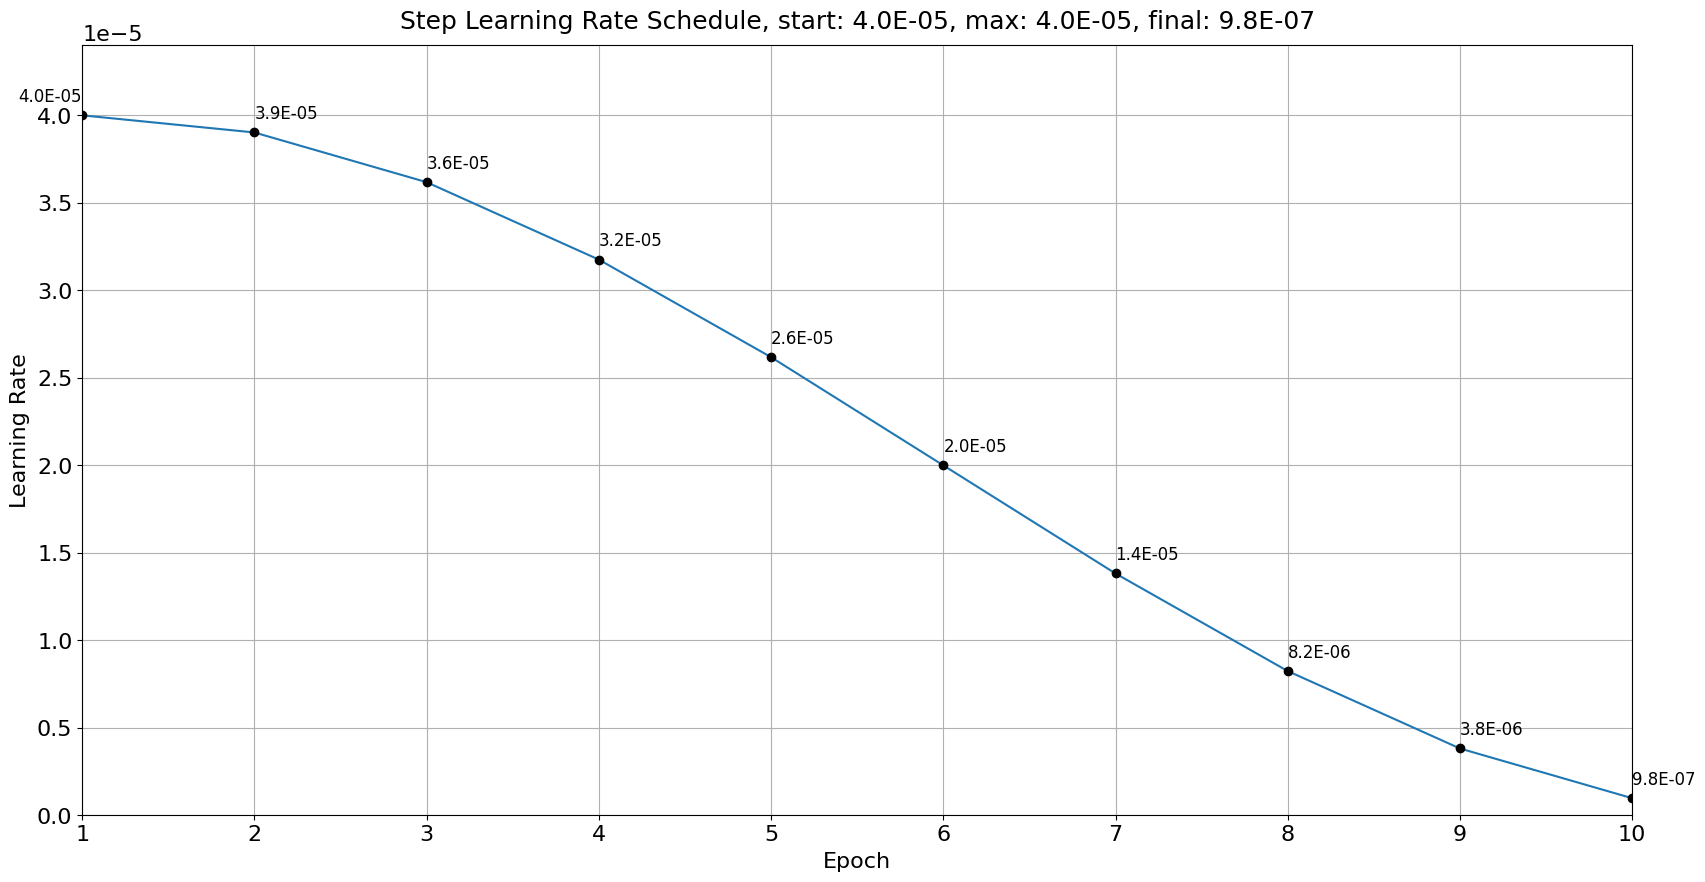

In [ ]:
# Learning rate scheduler with logaritmic warmup and cosine decay
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        return lr_max * 0.10 ** (num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

# Plot the learning rate scheduler
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)

In [ ]:
# Tensorflow Learning Rate Scheduler does not update weight decay, need to do it manually in a custom callback
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

In [ ]:
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

# Train model on TPU!
history = model.fit(
        train_dataset,
        steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
        validation_data = val_dataset,
        epochs = N_EPOCHS,
        verbose = VERBOSE,
        callbacks = [
            lr_callback,
            WeightDecayCallback(),
        ],
        class_weight = {
            0: 1.0,
            1: 5.0,
        },
    )

learning rate: 4.00e-05, weight decay: 4.00e-07
Epoch 1/10
685/685 - 718s - loss: 0.6734 - pF1: 0.1355 - f1_score: 0.1850 - precision: 0.1871 - recall: 0.1829 - auc: 0.6453 - binary_accuracy: 0.9011 - val_loss: 0.2092 - val_pF1: 0.0719 - val_f1_score: 0.2241 - val_precision: 0.1913 - val_recall: 0.2704 - val_auc: 0.7735 - val_binary_accuracy: 0.9665 - lr: 4.0000e-05 - 718s/epoch - 1s/step
learning rate: 3.90e-05, weight decay: 3.90e-07
Epoch 2/10
685/685 - 613s - loss: 0.4926 - pF1: 0.2598 - f1_score: 0.4140 - precision: 0.3653 - recall: 0.4775 - auc: 0.8411 - binary_accuracy: 0.9169 - val_loss: 0.2374 - val_pF1: 0.1056 - val_f1_score: 0.1881 - val_precision: 0.1150 - val_recall: 0.5153 - val_auc: 0.8243 - val_binary_accuracy: 0.9203 - lr: 3.9021e-05 - 613s/epoch - 895ms/step
learning rate: 3.62e-05, weight decay: 3.62e-07
Epoch 3/10
685/685 - 614s - loss: 0.3639 - pF1: 0.3840 - f1_score: 0.5560 - precision: 0.4735 - recall: 0.6733 - auc: 0.9209 - binary_accuracy: 0.9332 - val_loss: 0.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
